# Email Spam
The data for this example consists of information from 4601 email messages, in a study to try to predict whether the email was junk email, or “spam.” The objective was to design an automatic spam detector that could filter out spam before clogging the users’ mailboxes. For all 4601 email messages, the true outcome (email type) email or spam is available, along with the relative frequencies of 57 of the most commonly occurring words and punctuation marks in the email message. This is a supervised
learning problem, with the outcome the class variable email/spam. It is also called a classification problem.

For this problem not all errors are equal; we want to avoid filtering out good email, while letting spam get through is not desirable but less serious in its consequences. We discuss a number of different methods for tackling this learning problem in the book.

Variables:

|                          |                                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
|test                      |denotes wheter the record is train (0) or test(1)    |
|word_freq_WORD            |percentage of words in the e-mail that match WORD <br>continuous real [0,100]    |
|char_freq_CHAR            |percentage of characters in the e-mail that match CHAR<br>continuous real [0,100]|
|capital_run_length_average|average length of uninterrupted sequences of capital letters<br>continuous real [1,...]|
|capital_run_length_longest|length of longest uninterrupted sequence of capital letters<br>continuous integer [1,...]|
|capital_run_length_total  |sum of length of uninterrupted sequences of capital letters<br>continuous integer [1,...]|
|spam                      |denotes whether the e-mail was considered spam (1) or not (0),<br>i.e. unsolicited commercial e-mail|

## Load and Prepare Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [30]:
df = pd.read_csv("../data/Spam.txt")
target = ['spam']
columns = ['word_freq_make', 'word_freq_address', 'word_freq_all',
           'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove',
           'word_freq_internet', 'word_freq_order', 'word_freq_mail',
           'word_freq_receive', 'word_freq_will', 'word_freq_people',
           'word_freq_report', 'word_freq_addresses', 'word_freq_free',
           'word_freq_business', 'word_freq_email', 'word_freq_you',
           'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
           'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
           'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
           'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
           'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
           'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
           'word_freq_original', 'word_freq_project', 'word_freq_re',
           'word_freq_edu', 'word_freq_table', 'word_freq_conference',
           'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
           'char_freq_$', 'char_freq_#', 'capital_run_length_average',
           'capital_run_length_longest', 'capital_run_length_total']

features = ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet', 
            'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses', 
            'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000',
            'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857', 
            'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct', 
            'cs', 'meeting', 'original', 'project', 're', 'edu', 'table', 
            'conference', 'ch_;', 'ch(', 'ch[', 'ch!', 'ch$', 'ch#', 'CAPAVE',
            'CAPMAX', 'CAPTOT']

X, y = df[columns].values, df[target].values

# split by test column value
is_test = df.test.values
X_train, X_test = X[is_test==0], X[is_test==1]
y_train, y_test = y[is_test==0], y[is_test==1]
df.head()

,test,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Logistic Regression

In [3]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# PAGE 301. By comparison, a linear logistic regression has a test error rate of 7.6%.
ls = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
lr_error_rate = 1-accuracy_score(y_test, np.round(ls.predict(sm.add_constant(X_test))))
print(f'Logistic Regression Test Error Rate: {lr_error_rate*100:.1f}%')

# NOTE: you can get better result with logistic regression if log-transform features

Logistic Regression Test Error Rate: 7.6%


## Additive Logistic Regression
I used the pyGAM library for additive logistic regression. The result is close to the result from the book. But, unfortunately, I could not perform the predictors significance analysis, i.e. restore TABLE 9.2. Partial dependence plots look a little different. This is probably due to the fact that pyGAM uses B-splines, while the book uses natural cubic splines. It is also difficult to get 4 degrees of freedom for predictors, because you can only manipulate lambda. Perhaps in the future I will try to implement a simple version of GAM on my own.

In [5]:
from pygam import LogisticGAM
from sklearn.metrics import confusion_matrix

In [6]:
# with this lambda values we get about 4 df for predictors
lam = np.array([1.0000e+06, 5.0000e+02, 5.0000e+02, 1.0000e-01, 5.0000e+03, #1-5
                1.6453e+02, 4.1650e+01, 4.0000e+01, 8.0000e+01, 1.6453e+02, #6-10
                1.6453e+02, 3.2837e+02, 1.6453e+02, 8.2610e+01, 4.1650e+01, #11-15
                1.6453e+02, 8.2610e+01, 1.6453e+02, 3.2837e+02, 4.1650e+01, #16-20
                3.2837e+02, 1.0930e+01, 2.1170e+01, 4.1650e+01, 2.1170e+01, #21-25
                1.0930e+01, 7.0000e-01, 1.0930e+01, 7.0000e-01, 1.0930e+01, #26-30
                3.2500e+00, 7.0000e-01, 2.1170e+01, 1.0000e-01, 5.8100e+00, #31-35
                4.1650e+01, 8.2610e+01, 1.9700e+00, 1.0930e+01, 8.2610e+01, #36-40
                1.0000e-02, 8.5000e-01, 1.0000e+00, 5.8100e+00, 8.2610e+01, #41-45
                1.0930e+01, 1.0000e+00, 1.0000e+00, 8.2610e+01, 8.2610e+01, #46-50
                2.1170e+01, 1.6453e+02, 1.0000e+00, 1.0000e-01, 1.0000e+01, #51-55
                1.0000e-02, 1.0000e-02])                                    #56-57

In [7]:
X_train_log = np.log(X_train+0.1)
X_test_log = np.log(X_test+0.1)
gam = LogisticGAM(lam=lam).fit(X_train_log, y_train)

C:\Python64\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Python64\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
C:\Python64\lib\site-packages\pygam\pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)


In [8]:
cm = 100*confusion_matrix(y_test, gam.predict(X_test_log))/y_test.shape[0]
print(f'           |   Predicted Class  ')
print(f'           |----------------------')
print(f'True Class | email (0)  spam (1)')
print(f'----------------------------------')
print(f'email (0)  |     {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam (1)   |      {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
gam_error_rate = 1 - gam.accuracy(X_test_log, y_test)
print(f'\nGAM Test Error Rate: {gam_error_rate*100:.1f}%')

           |   Predicted Class  
           |----------------------
True Class | email (0)  spam (1)
----------------------------------
email (0)  |     58.6%     2.7%
spam (1)   |      2.6%    36.1%

GAM Test Error Rate: 5.3%


In [9]:
# refit linear logistic model to log-transformed features
ls = sm.Logit(y_train, sm.add_constant(X_train_log)).fit(disp=False)

# NOTE: this is not the TABLE 9.2. Nearly all values are from linear logistic
#       regression model. Only df are taken from GAM.
#       It is interesting to note that some features with low Nonlinear P-values
#       (see the book) have high P-values in linear logistic model
cov = ls.cov_params()
std_err = np.sqrt(np.diag(cov))
z_values = ls.params / std_err

print('Name      Num.   df  Coefficient  Std. Error  Z Score  P-value')
print('-----------------------------------------------------------------')
print('                       Positive effects')
for p in ['our', 'over', 'remove', 'internet', 'free', 'business',
          'hpl', 'ch!', 'ch$', 'CAPMAX', 'CAPTOT',
          'hp', 'george', '1999', 're', 'edu']:
    if p == 'hp':
        print('                       Negative effects')
    idx = features.index(p)
    edof = gam.statistics_['edof_per_coef'][gam.terms.get_coef_indices(idx)].sum()
    cf = ls.params[idx+1]
    print(f'{p:<10}{idx+1:>3}{edof:>6.1f}{cf:>10.3f}{std_err[idx+1]:>13.3f}'
          f'{z_values[idx+1]:>10.3f}{ls.pvalues[idx+1]:>9.3f}')

Name      Num.   df  Coefficient  Std. Error  Z Score  P-value
-----------------------------------------------------------------
                       Positive effects
our         5   4.1     0.444        0.091     4.899    0.000
over        6   3.9     0.198        0.159     1.246    0.213
remove      7   3.7     0.950        0.161     5.908    0.000
internet    8   3.8     0.424        0.150     2.835    0.005
free       16   3.1     0.506        0.098     5.174    0.000
business   17   3.0     0.604        0.153     3.939    0.000
hpl        26   2.3     0.027        0.202     0.135    0.892
ch!        52   1.5     0.754        0.102     7.372    0.000
ch$        53   1.4     1.421        0.227     6.261    0.000
CAPMAX     56   2.5     0.056        0.187     0.298    0.766
CAPTOT     57   3.4     0.572        0.138     4.149    0.000
                       Negative effects
hp         25   3.0    -1.348        0.195    -6.898    0.000
george     27   2.2    -3.966        0.707    -

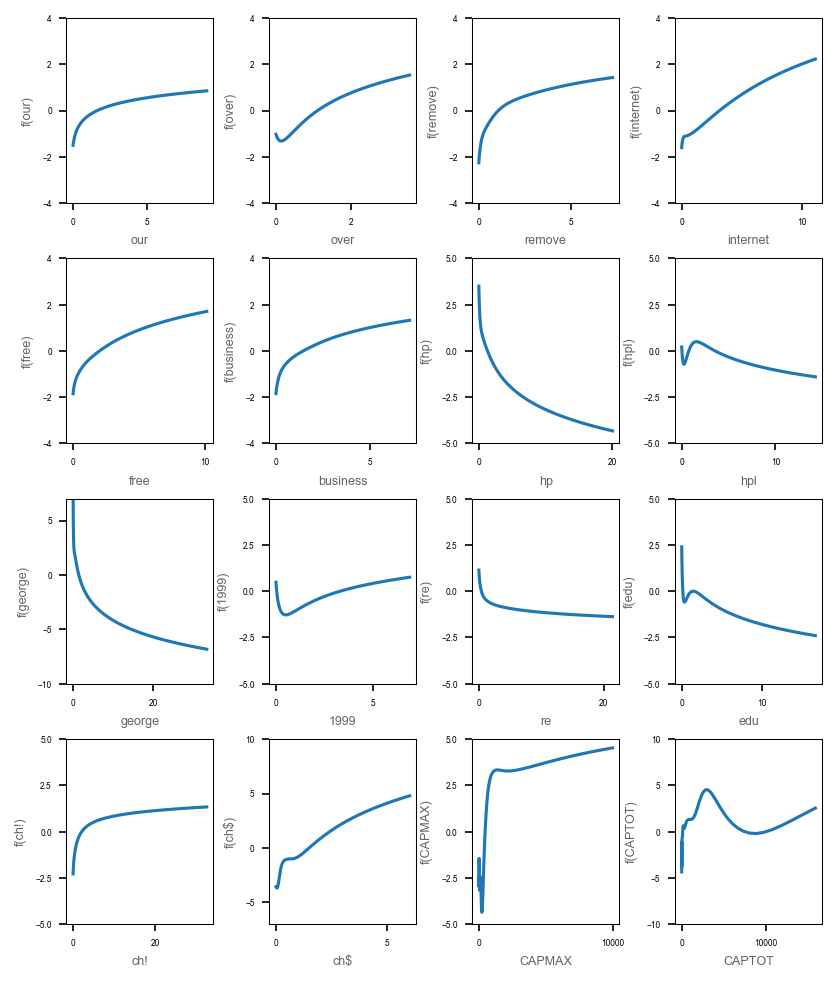

In [10]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY4 = '#646369'

fig, axarr = plt.subplots(4, 4, figsize=(6.5, 8), dpi=150)
plt.subplots_adjust(wspace=0.38, hspace=0.3)

def dependance_plot(ax, i, ylim):
    i = i-1
    X_grid = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=X_grid, width=0.95)
    ax.plot(np.exp(X_grid[:, i])-0.1, pdep)
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(4)
    ax.set_ylabel(f'f({features[i]})', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{features[i]}', color=GRAY4, fontsize=6)
    # uncomment to see observed values in train dataset
    #for o in range(X_train.shape[0]):
    #    x = X_train[o, i]
    #    ax.plot([x, x], [ylim[0], ylim[0]+(ylim[1]-ylim[0])*0.04], 
    #             color='red', linewidth=0.5)
    ax.set_ylim(ylim)

dependance_plot(axarr[0, 0], 5, (-4, 4))
dependance_plot(axarr[0, 1], 6, (-4, 4))
dependance_plot(axarr[0, 2], 7, (-4, 4))
dependance_plot(axarr[0, 3], 8, (-4, 4))

dependance_plot(axarr[1, 0], 16, (-4, 4))
dependance_plot(axarr[1, 1], 17, (-4, 4))
dependance_plot(axarr[1, 2], 25, (-5, 5))
dependance_plot(axarr[1, 3], 26, (-5, 5))

dependance_plot(axarr[2, 0], 27, (-10, 7))
dependance_plot(axarr[2, 1], 37, (-5, 5))
dependance_plot(axarr[2, 2], 45, (-5, 5))
dependance_plot(axarr[2, 3], 46, (-5, 5))

dependance_plot(axarr[3, 0], 52, (-5, 5))
dependance_plot(axarr[3, 1], 53, (-7, 10))
dependance_plot(axarr[3, 2], 56, (-5, 5))
dependance_plot(axarr[3, 3], 57, (-10, 10))

## Decision Tree

In [26]:
from sklearn import tree

In [37]:
# NOTE: you can get better result with criterin='gini'
clf = tree.DecisionTreeClassifier(max_leaf_nodes=17, criterion='entropy')
clf.fit(X_train, y_train)
y_test_hat = clf.predict(X_test)
tr_error_rate = 1-accuracy_score(y_test, y_test_hat)

cm = 100*confusion_matrix(y_test, y_test_hat)/y_test.shape[0]
print(f'       |     Predicted  ')
print(f'       |----------------')
print(f'True   | email     spam ')
print(f'------------------------')
print(f'email  | {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam   |  {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
gam_error_rate = 1 - gam.accuracy(X_test, y_test)
print(f'\nDecision Tree Test Error Rate: {tr_error_rate*100:.1f}%')

       |     Predicted  
       |----------------
True   | email     spam 
------------------------
email  | 57.3%     4.0%
spam   |  5.4%    33.3%

Decision Tree Test Error Rate: 9.4%


C:\Python64\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
C:\Python64\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
C:\Python64\lib\site-packages\pygam\pygam.py:2426: RuntimeWarning: invalid value encountered in greater
  return ((mu > 0.5).astype(int) == y).mean()


In [38]:
import os     
import pydotplus
import collections
from IPython.display import Image, display
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

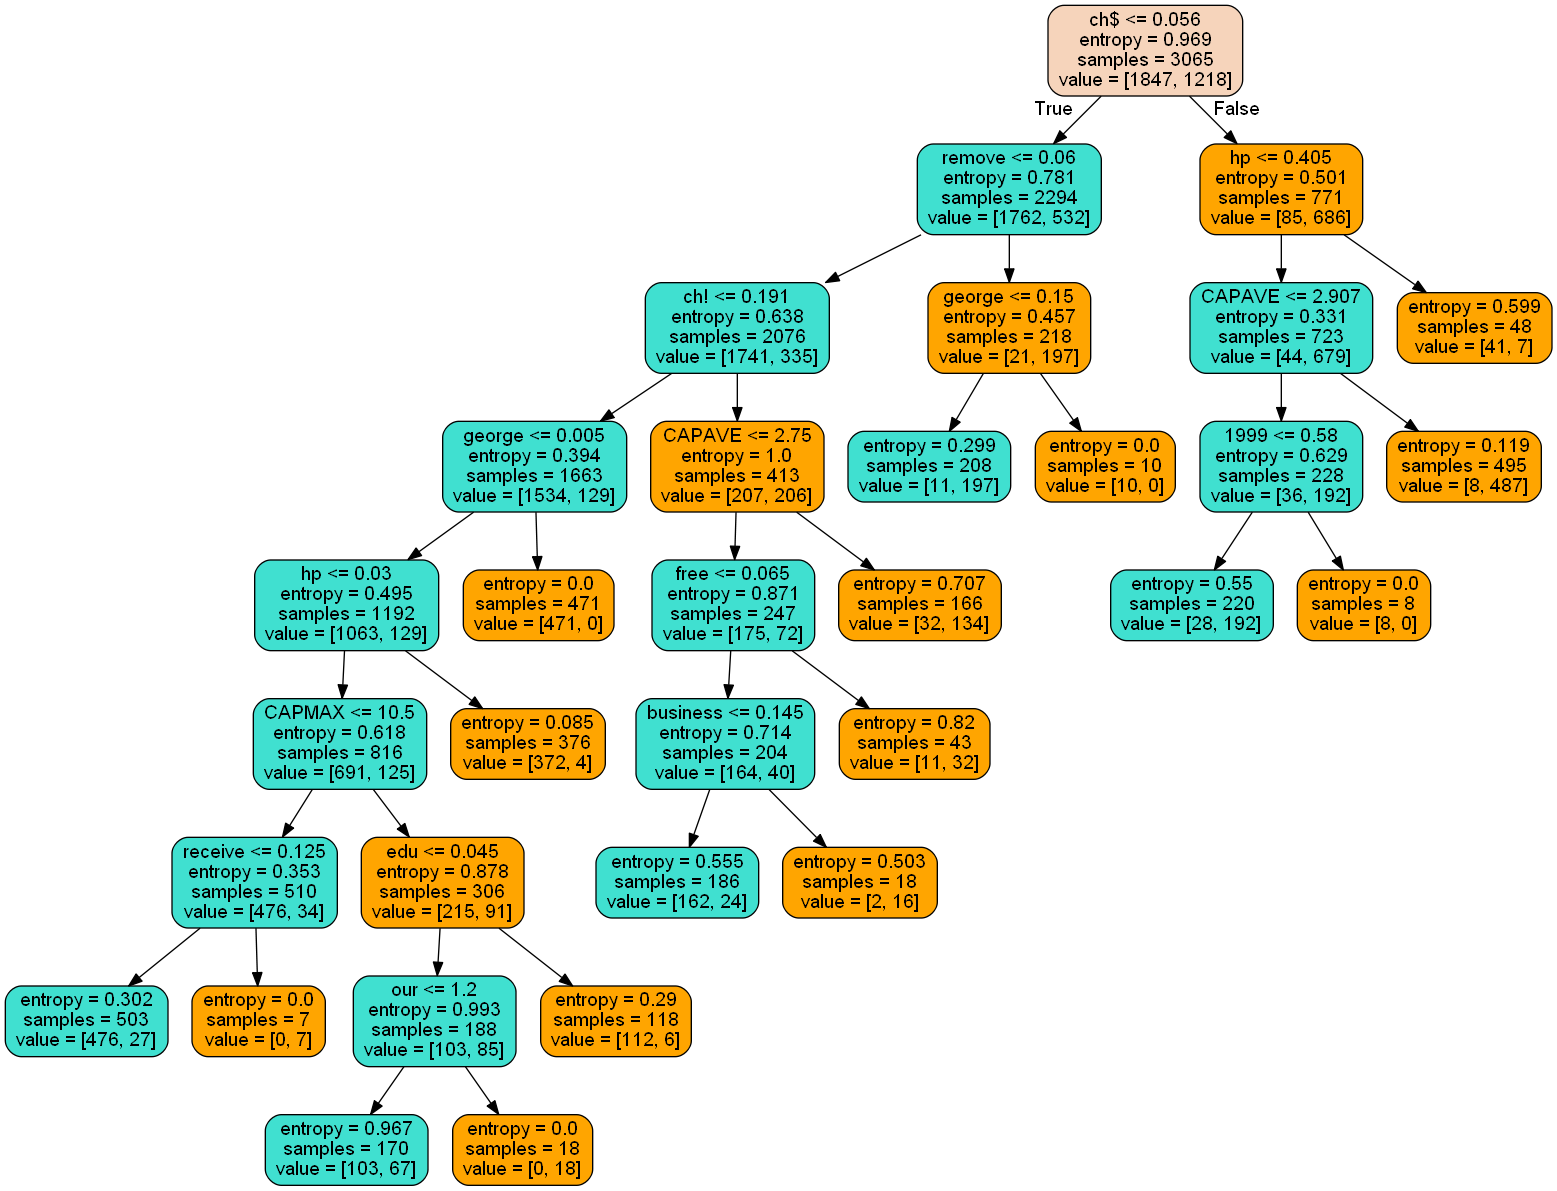

In [39]:
dot_data = tree.export_graphviz(clf,
                                feature_names=features,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

display(Image(graph.create_png()))

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

In [107]:
#X = np.log(df.values[:,:-1]+0.1)
X = df.values[:,:-1]
y = df['spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3065, random_state=70)

C:\Python64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [128]:
gbt = GradientBoostingClassifier(n_estimators=500, max_depth=2)
gbt = gbt.fit(X_train, y_train)
y_test_hat = gbt.predict(X_test)

In [129]:
1 - accuracy_score(y_test, y_test_hat)

0.048828125

In [130]:
#list(zip(range(len(df.columns)), df.columns))

In [131]:
sorted(list(zip(gbt.feature_importances_, df.columns[:-1])))

[(0.0, 'word_freq_415'),
 (0.0, 'word_freq_857'),
 (0.0, 'word_freq_addresses'),
 (0.0, 'word_freq_table'),
 (0.0, 'word_freq_telnet'),
 (0.0011325109575670113, 'word_freq_85'),
 (0.002179137543590785, 'word_freq_make'),
 (0.00234987137293521, 'word_freq_cs'),
 (0.002352950278164774, 'word_freq_direct'),
 (0.0027393100191102694, 'word_freq_lab'),
 (0.0037555751352333403, 'word_freq_hpl'),
 (0.003956675188995516, 'word_freq_labs'),
 (0.004387617258324066, 'word_freq_original'),
 (0.004967554722645783, 'word_freq_project'),
 (0.0052070470308764535, 'word_freq_address'),
 (0.0054540929164152065, 'word_freq_3d'),
 (0.0058236651259227145, 'char_freq_['),
 (0.006457025819769674, 'char_freq_#'),
 (0.007588495373049742, 'word_freq_pm'),
 (0.00779331572984286, 'word_freq_report'),
 (0.007823943909867497, 'word_freq_parts'),
 (0.009004735981241815, 'word_freq_people'),
 (0.009551867470160317, 'word_freq_data'),
 (0.010217072640652242, 'word_freq_conference'),
 (0.010670135165360388, 'word_freq_0

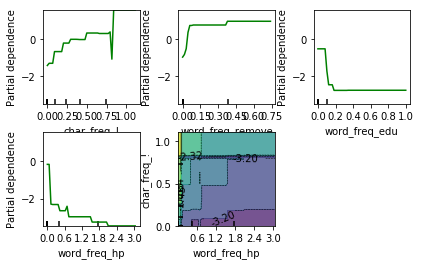

In [132]:
features = [51, 6, 45, 24, (24, 51)]
fig, axs = plot_partial_dependence(gbt, X_train, features,
                                       feature_names=df.columns,
                                       n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9)

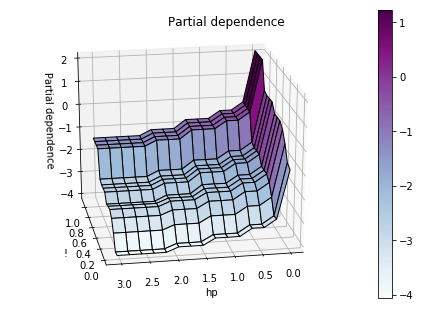

In [133]:
fig = plt.figure()

target_feature = (24, 51)
pdp, axes = partial_dependence(gbt, target_feature, X=X_train, grid_resolution=15)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('hp')
ax.set_ylabel('!')
ax.set_zlabel('Partial dependence')
ax.invert_yaxis()
ax.view_init(elev=22, azim=80)
plt.colorbar(surf)
plt.suptitle('Partial dependence')
plt.subplots_adjust(top=0.9)
plt.show()